# TB Drug Susceptibility Testing: Data Analysis

**Project:** Area-based approach for antibiotic resistance classification

## Overview

This notebook analyzes bacterial growth data from time-lapse microscopy experiments to understand:
- Growth patterns of resistant (REF) vs. susceptible (RIF10) strains
- Differences between sparse timepoint sampling and continuous tracking
- Environmental variability across microfluidic chambers
- Optimal timepoints for early detection

## Dataset

- **REF (Untreated/Resistant):** Positions 101-110 (10 samples)
- **RIF10 (Rifampicin 10 mg/L/Susceptible):** Positions 201-220 (20 samples)
- **Duration:** 12 hours
- **Frame interval:** 6 minutes (0.1 hours)
- **Total frames:** ~121 per position

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Libraries imported successfully!")

✓ Libraries imported successfully!


### Configuration

**Update these paths to match your data location:**

In [5]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# For Google Colab
USE_COLAB = True  # Set to False if running locally

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/data"  # Update this path
else:
    BASE_DIR = "./data"  # Local path

# Data directories
REF_MASK_DIR = Path(BASE_DIR) / "REF_masks101_110"
RIF_MASK_DIR = Path(BASE_DIR) / "RIF10_masks201_210"

# Output directory for figures
OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Constants
PIXEL_SIZE = 0.065  # μm per pixel
FRAME_INTERVAL = 0.1  # hours per frame
SPARSE_TIMEPOINTS = [0, 3, 6, 9, 12]  # hours

print(f" Configuration complete")
print(f"  REF directory: {REF_MASK_DIR}")
print(f"  RIF10 directory: {RIF_MASK_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Configuration complete
  REF directory: /content/drive/MyDrive/data/REF_masks101_110
  RIF10 directory: /content/drive/MyDrive/data/RIF10_masks201_210
  Output directory: outputs


## 2. Load Data

In [6]:
def load_area_data(mask_base_dir, position_range=(101, 110), pixel_size=0.065):
    """
    Load bacterial area measurements from mask TIFF files.

    Parameters:
    -----------
    mask_base_dir : str or Path
        Base directory containing position folders
    position_range : tuple
        Range of position numbers (start, end) inclusive
    pixel_size : float
        Pixel size in micrometers

    Returns:
    --------
    dict : {position_name: area_array}
        Dictionary mapping position names to arrays of bacterial areas (μm²)
    """
    mask_base_path = Path(mask_base_dir)
    positions = list(range(position_range[0], position_range[1] + 1))
    area_data = {}

    for position in positions:
        pos_string = f'Pos{position}'
        mask_dir = mask_base_path / pos_string / 'PreprocessedPhaseMasks'

        if not mask_dir.exists():
            print(f" Directory not found: {pos_string}")
            continue

        # Get all mask files
        mask_files = sorted([f for f in mask_dir.iterdir()
                           if f.name.startswith('MASK_') and f.name.endswith('.tif')])

        if not mask_files:
            print(f"  No mask files found: {pos_string}")
            continue

        # Calculate bacterial area from each mask
        areas = []
        for mask_file in mask_files:
            mask = np.array(Image.open(mask_file)) > 0
            area_pixels = mask.sum()
            area_um2 = area_pixels * (pixel_size ** 2)
            areas.append(area_um2)

        area_data[pos_string] = np.array(areas)
        print(f"  {pos_string}: {len(areas)} timepoints")

    return area_data


# Load REF data (untreated/resistant)
print("Loading REF (untreated) data...")
ref_areas = load_area_data(REF_MASK_DIR, position_range=(101, 110))
print(f"\n Loaded {len(ref_areas)} REF positions\n")

# Load RIF10 data (treated/susceptible)
print("Loading RIF10 (rifampicin-treated) data...")
rif10_areas = load_area_data(RIF_MASK_DIR, position_range=(201, 220))
print(f"\n Loaded {len(rif10_areas)} RIF10 positions")

Loading REF (untreated) data...
  Pos101: 121 timepoints
  Pos102: 121 timepoints
  Pos103: 121 timepoints
  Pos104: 121 timepoints
  Pos105: 121 timepoints
  Pos106: 121 timepoints
  Pos107: 121 timepoints
  Pos108: 121 timepoints
  Pos109: 121 timepoints
  Pos110: 121 timepoints

 Loaded 10 REF positions

Loading RIF10 (rifampicin-treated) data...
  Pos201: 121 timepoints
  Pos202: 121 timepoints
  Pos203: 121 timepoints
  Pos204: 121 timepoints
  Pos205: 121 timepoints
  Pos206: 121 timepoints
  Pos207: 121 timepoints
  Pos208: 121 timepoints
  Pos209: 121 timepoints
  Pos210: 121 timepoints
  Pos211: 121 timepoints
  Pos212: 121 timepoints
  Pos213: 121 timepoints
  Pos214: 121 timepoints
  Pos215: 121 timepoints
  Pos216: 121 timepoints
  Pos217: 121 timepoints
  Pos218: 121 timepoints
  Pos219: 121 timepoints
  Pos220: 121 timepoints

 Loaded 20 RIF10 positions


## 3. Data Overview

In [7]:
ref_full = np.array([ref_areas[k] for k in sorted(ref_areas.keys())], dtype=object)
rif10_full = np.array([rif10_areas[k] for k in sorted(rif10_areas.keys())], dtype=object)

# Truncate to minimum length
ref_min_len = min(len(arr) for arr in ref_full)
rif10_min_len = min(len(arr) for arr in rif10_full)

ref_full = np.array([arr[:ref_min_len] for arr in ref_full])
rif10_full = np.array([arr[:rif10_min_len] for arr in rif10_full])

# Time arrays
time_ref = np.arange(ref_full.shape[1]) * FRAME_INTERVAL
time_rif = np.arange(rif10_full.shape[1]) * FRAME_INTERVAL

print("DATA SUMMARY")
print(f"\nREF (Resistant):")
print(f"  Samples: {ref_full.shape[0]}")
print(f"  Timepoints: {ref_full.shape[1]}")
print(f"  Duration: {time_ref[-1]:.1f} hours")
print(f"  Initial area: {ref_full[:, 0].mean():.2f} ± {ref_full[:, 0].std():.2f} μm²")
print(f"  Final area:   {ref_full[:, -1].mean():.2f} ± {ref_full[:, -1].std():.2f} μm²")

print(f"\nRIF10 (Susceptible):")
print(f"  Samples: {rif10_full.shape[0]}")
print(f"  Timepoints: {rif10_full.shape[1]}")
print(f"  Duration: {time_rif[-1]:.1f} hours")
print(f"  Initial area: {rif10_full[:, 0].mean():.2f} ± {rif10_full[:, 0].std():.2f} μm²")
print(f"  Final area:   {rif10_full[:, -1].mean():.2f} ± {rif10_full[:, -1].std():.2f} μm²")

DATA SUMMARY

REF (Resistant):
  Samples: 10
  Timepoints: 121
  Duration: 12.0 hours
  Initial area: 61.77 ± 31.26 μm²
  Final area:   177.96 ± 103.50 μm²

RIF10 (Susceptible):
  Samples: 20
  Timepoints: 121
  Duration: 12.0 hours
  Initial area: 75.23 ± 37.37 μm²
  Final area:   109.97 ± 59.74 μm²


## 4. Visualize Growth Trajectories

### 4.1 Full Continuous Tracking

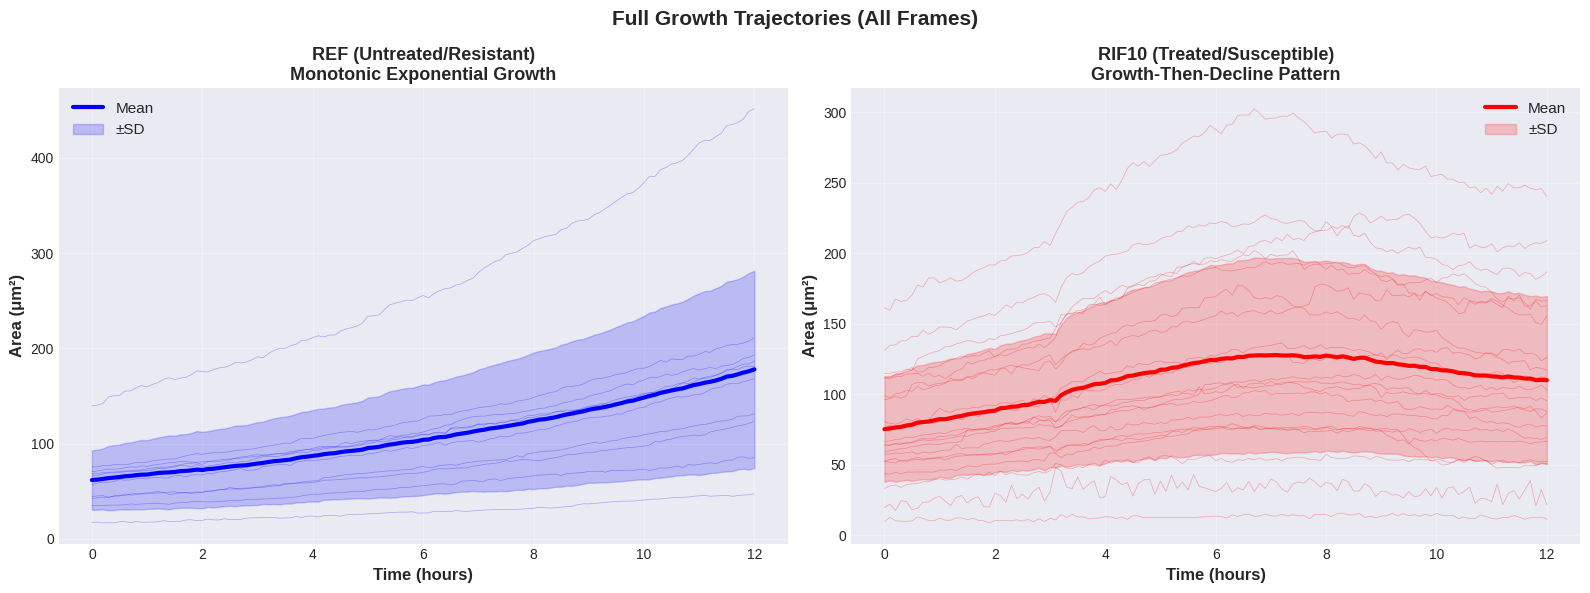

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ref_full = ref_full.astype(float)
rif10_full = rif10_full.astype(float)

# Calculate statistics
ref_mean = np.mean(ref_full, axis=0)
ref_std = np.std(ref_full, axis=0)
rif_mean = np.mean(rif10_full, axis=0)
rif_std = np.std(rif10_full, axis=0)

# REF trajectories
ax1.plot(time_ref, ref_full.T, alpha=0.3, color='blue', linewidth=0.5)
ax1.plot(time_ref, ref_mean, 'b-', linewidth=3, label='Mean', zorder=10)
ax1.fill_between(time_ref,
                  ref_mean - ref_std,
                  ref_mean + ref_std,
                  alpha=0.2, color='blue', label='±SD')
ax1.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Area (μm²)', fontsize=12, fontweight='bold')
ax1.set_title('REF (Untreated/Resistant)\nMonotonic Exponential Growth',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# RIF10 trajectories
ax2.plot(time_rif, rif10_full.T, alpha=0.3, color='red', linewidth=0.5)
ax2.plot(time_rif, rif_mean, 'r-', linewidth=3, label='Mean', zorder=10)
ax2.fill_between(time_rif,
                  rif_mean - rif_std,
                  rif_mean + rif_std,
                  alpha=0.2, color='red', label='±SD')
ax2.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Area (μm²)', fontsize=12, fontweight='bold')
ax2.set_title('RIF10 (Treated/Susceptible)\nGrowth-Then-Decline Pattern',
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('Full Growth Trajectories (All Frames)',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'growth_trajectories_full.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.2 Sparse Timepoints (Proposed Approach)

In [13]:
def extract_sparse_timepoints(area_timeseries, target_hours=[0, 3, 6, 9, 12],
                              frame_interval_hours=0.1):
    """
    Extract area measurements at specific timepoints.

    Parameters:
    -----------
    area_timeseries : array
        Full timeseries of area measurements
    target_hours : list
        Target timepoints in hours
    frame_interval_hours : float
        Time between frames in hours

    Returns:
    --------
    array : Areas at target timepoints
    """
    frame_indices = [int(h / frame_interval_hours) for h in target_hours]
    max_frame = len(area_timeseries) - 1
    frame_indices = [min(idx, max_frame) for idx in frame_indices]
    return area_timeseries[frame_indices]


# Extract sparse timepoints
ref_sparse = np.array([extract_sparse_timepoints(area, SPARSE_TIMEPOINTS, FRAME_INTERVAL)
                       for area in ref_full])
rif10_sparse = np.array([extract_sparse_timepoints(area, SPARSE_TIMEPOINTS, FRAME_INTERVAL)
                         for area in rif10_full])

print(f"Original frames: {ref_full.shape[1]}")
print(f"Sparse timepoints: {len(SPARSE_TIMEPOINTS)}")
print(f"Reduction: {(1 - len(SPARSE_TIMEPOINTS)/ref_full.shape[1])*100:.1f}%")

Original frames: 121
Sparse timepoints: 5
Reduction: 95.9%


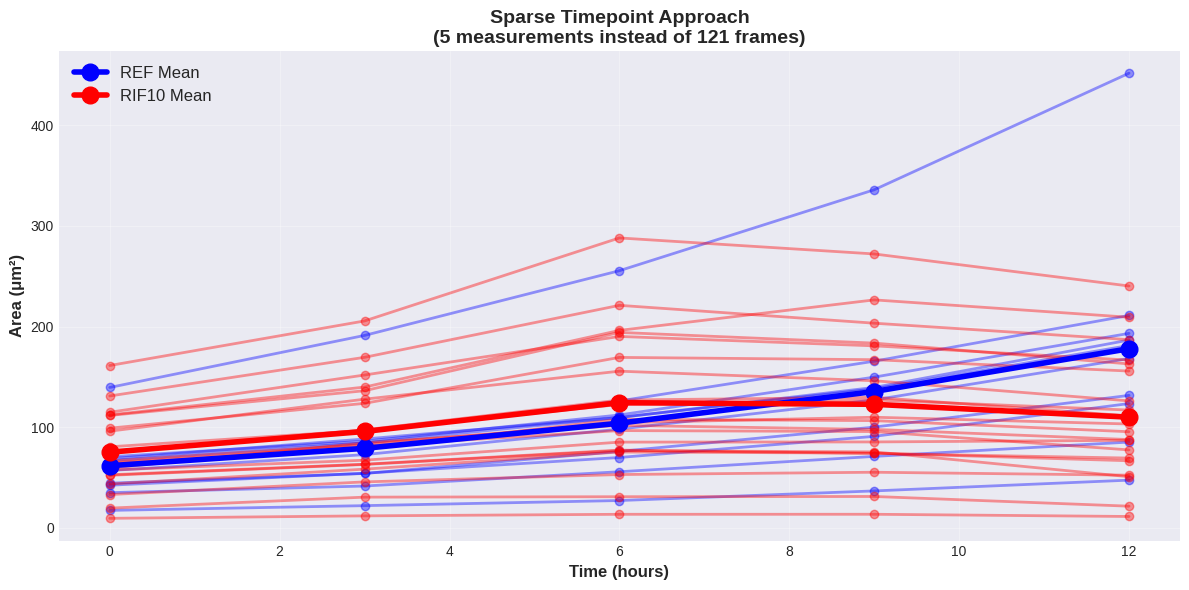

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# REF sparse
for i in range(ref_sparse.shape[0]):
    ax.plot(SPARSE_TIMEPOINTS, ref_sparse[i], 'bo-', alpha=0.4, linewidth=2)
ax.plot(SPARSE_TIMEPOINTS, ref_sparse.mean(axis=0), 'b-', linewidth=4,
        marker='o', markersize=12, label='REF Mean', zorder=10)

# RIF10 sparse
for i in range(rif10_sparse.shape[0]):
    ax.plot(SPARSE_TIMEPOINTS, rif10_sparse[i], 'ro-', alpha=0.4, linewidth=2)
ax.plot(SPARSE_TIMEPOINTS, rif10_sparse.mean(axis=0), 'r-', linewidth=4,
        marker='o', markersize=12, label='RIF10 Mean', zorder=10)

ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
ax.set_ylabel('Area (μm²)', fontsize=12, fontweight='bold')
ax.set_title('Sparse Timepoint Approach\n(5 measurements instead of 121 frames)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'growth_trajectories_sparse.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Growth Pattern Analysis

### 5.1 Peak Detection in RIF10

In [16]:
# Analyze peak timing for RIF10 samples
peak_times = []
peak_areas = []

for i in range(rif10_full.shape[0]):
    peak_idx = np.argmax(rif10_full[i])
    peak_time = time_rif[peak_idx]
    peak_area = rif10_full[i, peak_idx]
    peak_times.append(peak_time)
    peak_areas.append(peak_area)

print("RIF10 PEAK ANALYSIS")
print(f"\nPeak time: {np.mean(peak_times):.2f} ± {np.std(peak_times):.2f} hours")
print(f"Peak area: {np.mean(peak_areas):.2f} ± {np.std(peak_areas):.2f} μm²")
print(f"\nPeaks occur between {np.min(peak_times):.1f}h and {np.max(peak_times):.1f}h")
print(f"Median peak time: {np.median(peak_times):.1f}h")

RIF10 PEAK ANALYSIS

Peak time: 7.54 ± 1.64 hours
Peak area: 132.34 ± 70.06 μm²

Peaks occur between 3.1h and 11.7h
Median peak time: 7.3h


### 5.2 Growth Rate Calculation

In [17]:
def calculate_growth_rates(sparse_areas, dt=3):
    """
    Calculate growth rates between consecutive timepoints.

    Growth rate: r = (A[t+1] - A[t]) / (A[t] * dt)

    Parameters:
    -----------
    sparse_areas : array (n_samples, n_timepoints)
        Area measurements at sparse timepoints
    dt : float
        Time interval between consecutive points (hours)

    Returns:
    --------
    array : Growth rates (n_samples, n_intervals)
    """
    n_samples, n_timepoints = sparse_areas.shape
    n_intervals = n_timepoints - 1
    rates = np.zeros((n_samples, n_intervals))

    for i in range(n_samples):
        for j in range(n_intervals):
            if sparse_areas[i, j] > 0:
                rates[i, j] = (sparse_areas[i, j+1] - sparse_areas[i, j]) / \
                              (sparse_areas[i, j] * dt)

    return rates


ref_rates = calculate_growth_rates(ref_sparse, dt=3)
rif10_rates = calculate_growth_rates(rif10_sparse, dt=3)

# Time points for rates (midpoints of intervals)
rate_times = [1.5, 4.5, 7.5, 10.5]

print("Growth rates calculated successfully!")
print(f"  REF rates shape: {ref_rates.shape}")
print(f"  RIF10 rates shape: {rif10_rates.shape}")

Growth rates calculated successfully!
  REF rates shape: (10, 4)
  RIF10 rates shape: (20, 4)


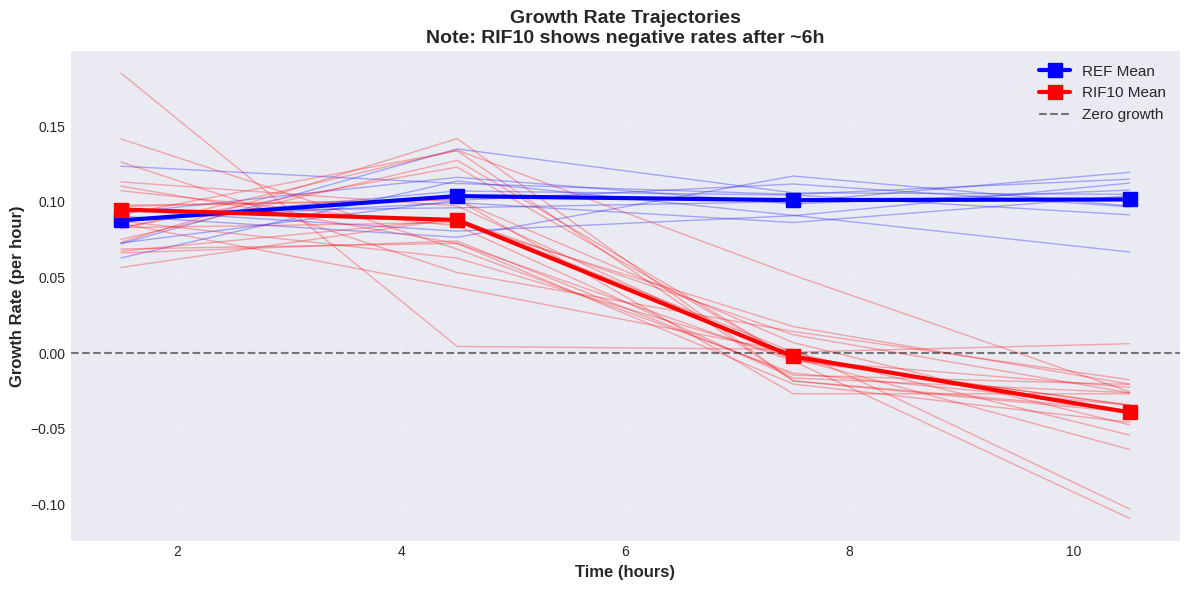

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

# Individual trajectories
ax.plot(rate_times, ref_rates.T, 'b-', alpha=0.3, linewidth=1)
ax.plot(rate_times, rif10_rates.T, 'r-', alpha=0.3, linewidth=1)

# Means
ax.plot(rate_times, ref_rates.mean(axis=0), 'b-', linewidth=3,
        marker='s', markersize=10, label='REF Mean', zorder=10)
ax.plot(rate_times, rif10_rates.mean(axis=0), 'r-', linewidth=3,
        marker='s', markersize=10, label='RIF10 Mean', zorder=10)

ax.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='Zero growth')
ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
ax.set_ylabel('Growth Rate (per hour)', fontsize=12, fontweight='bold')
ax.set_title('Growth Rate Trajectories\nNote: RIF10 shows negative rates after ~6h',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'growth_rates.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Environmental Variability Analysis

Check if initial bacterial loads are consistent across samples. High variability (8-12× range) indicates random seeding differences, not environmental factors.

In [20]:
# Analyze variability in initial and final areas
ref_initial = ref_sparse[:, 0]
ref_final = ref_sparse[:, -1]
rif10_initial = rif10_sparse[:10, 0]  # Only "paired" positions 201-210
rif10_final = rif10_sparse[:10, -1]

print("ENVIRONMENTAL VARIABILITY")
print(f"\nREF Initial Areas:")
print(f"  Range: {ref_initial.min():.1f} - {ref_initial.max():.1f} μm²")
print(f"  Fold difference: {ref_initial.max() / ref_initial.min():.2f}×")
print(f"  CV: {(ref_initial.std() / ref_initial.mean())*100:.1f}%")

print(f"\nRIF10 Initial Areas (Pos201-210):")
print(f"  Range: {rif10_initial.min():.1f} - {rif10_initial.max():.1f} μm²")
print(f"  Fold difference: {rif10_initial.max() / rif10_initial.min():.2f}×")
print(f"  CV: {(rif10_initial.std() / rif10_initial.mean())*100:.1f}%")


ENVIRONMENTAL VARIABILITY

REF Initial Areas:
  Range: 17.4 - 139.5 μm²
  Fold difference: 8.02×
  CV: 50.6%

RIF10 Initial Areas (Pos201-210):
  Range: 43.6 - 131.0 μm²
  Fold difference: 3.01×
  CV: 33.1%


## 7. Summary Statistics Table

In [23]:
summary_data = []

for i in range(10):
    ref_pos = f'Pos{101+i}'
    rif_pos = f'Pos{201+i}'

    ref_growth = (ref_sparse[i, -1] - ref_sparse[i, 0]) / ref_sparse[i, 0] * 100
    rif_growth = (rif10_sparse[i, -1] - rif10_sparse[i, 0]) / rif10_sparse[i, 0] * 100

    summary_data.append({
        'Pair': f'{ref_pos}↔{rif_pos}',
        'REF_Initial': ref_sparse[i, 0],
        'REF_Final': ref_sparse[i, -1],
        'REF_Growth_%': ref_growth,
        'RIF10_Initial': rif10_sparse[i, 0],
        'RIF10_Final': rif10_sparse[i, -1],
        'RIF10_Growth_%': rif_growth
    })

df_summary = pd.DataFrame(summary_data)

print("GROWTH SUMMARY TABLE")
print(df_summary.to_string(index=False, float_format=lambda x: f'{x:.1f}'))


df_summary.to_csv(OUTPUT_DIR / 'growth_summary.csv', index=False)

GROWTH SUMMARY TABLE
         Pair  REF_Initial  REF_Final  REF_Growth_%  RIF10_Initial  RIF10_Final  RIF10_Growth_%
Pos101↔Pos201         44.4      131.6         196.1          114.9        166.7            45.1
Pos102↔Pos202         42.4      123.5         191.3           59.3         87.7            48.0
Pos103↔Pos203         17.4       47.4         172.8           96.1        126.2            31.3
Pos104↔Pos204         68.8      186.6         171.2           52.8         69.4            31.5
Pos105↔Pos205         35.0       85.3         143.6          112.2        209.2            86.4
Pos106↔Pos206         75.6      211.0         178.9           43.6         66.7            53.0
Pos107↔Pos207         66.9      181.2         170.8          131.0        187.0            42.7
Pos108↔Pos208         57.0      168.2         195.3           63.7         95.5            50.0
Pos109↔Pos209        139.5      451.6         223.7           99.1        155.8            57.3
Pos110↔Pos210      